In [1]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from model import SpeechRecognition
from dataLoader import Data, collate_fn_padd
import matplotlib.pyplot as plt
device = "cuda:0"

batchSize = 64
numWorkers = 8
def train_dataloader():
    d_params = Data.parameters
    train_dataset = Data(json_path="data/train.json", **d_params)
    return DataLoader(dataset=train_dataset,
                        batch_size=batchSize,
                        num_workers=numWorkers,
                        pin_memory=True,
                        collate_fn=collate_fn_padd)
def valid_dataloader():
    d_params = Data.parameters
    valid_dataset = Data(json_path="data/test.json", **d_params)
    return DataLoader(dataset=valid_dataset,
                        batch_size=batchSize,
                        num_workers=numWorkers,
                        pin_memory=True,
                        collate_fn=collate_fn_padd)

trainLoader = train_dataloader()
validLoader = valid_dataloader()

In [2]:
def train(model, optimizer, criterion, numEpochs=10, title="Model"):
    trnLoss = []
    valLoss = []
    for epoch in range(numEpochs):
        model.train()
        tmpTrnLoss = []
        for i, (spectrograms, labels, input_lengths, label_lengths) in enumerate(trainLoader): 
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            bs = spectrograms.shape[0]
            hidden = model._init_hidden(bs)
            hn, c0 = hidden[0].to(device), hidden[1].to(device)
            output, _ = model(spectrograms, (hn, c0))
            output = F.log_softmax(output, dim=2)
            loss = criterion(output, labels, input_lengths, label_lengths)
            tmpTrnLoss.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        trnLoss.append(torch.mean(torch.tensor(tmpTrnLoss)))
        print(f"Train Epoch [{epoch+1}/{numEpochs}], Loss: {loss.item():.4f}")
        model.eval()
        tmpValLoss = []
        with torch.no_grad():
            for i, (spectrograms, labels, input_lengths, label_lengths) in enumerate(validLoader):
                spectrograms, labels = spectrograms.to(device), labels.to(device)
                bs = spectrograms.shape[0]
                hidden = model._init_hidden(bs)
                hn, c0 = hidden[0].to(device), hidden[1].to(device)
                output, _ = model(spectrograms, (hn, c0))
                output = F.log_softmax(output, dim=2)
                loss = criterion(output, labels, input_lengths, label_lengths)
                tmpValLoss.append(loss)
            print(f"Valid Epoch [{epoch+1}/{numEpochs}], Loss: {loss.item():.4f}")
            valLoss.append(torch.mean(torch.tensor(tmpValLoss)))
    return trnLoss, valLoss
srmodel = SpeechRecognition().to(device)
optimizer = optim.AdamW(srmodel.parameters(), 1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min',
    factor=0.50, patience=6)
criterion = nn.CTCLoss(blank=28, zero_infinity=True)
trnLoss, valLoss = train(srmodel, optimizer, criterion, 100)

Train Epoch [1/100], Loss: 6.2468
Valid Epoch [1/100], Loss: 6.3752
Train Epoch [2/100], Loss: 5.7731
Valid Epoch [2/100], Loss: 5.8767
Train Epoch [3/100], Loss: 5.8426
Valid Epoch [3/100], Loss: 5.9371
Train Epoch [4/100], Loss: 6.0582
Valid Epoch [4/100], Loss: 6.1105
Train Epoch [5/100], Loss: 6.1442
Valid Epoch [5/100], Loss: 6.0745
Train Epoch [6/100], Loss: 6.7455
Valid Epoch [6/100], Loss: 6.2588
Train Epoch [7/100], Loss: 7.3555
Valid Epoch [7/100], Loss: 6.2288
Train Epoch [8/100], Loss: 5.7720
Valid Epoch [8/100], Loss: 5.2847
Train Epoch [9/100], Loss: 3.3613
Valid Epoch [9/100], Loss: 3.2673
Train Epoch [10/100], Loss: 2.9785
Valid Epoch [10/100], Loss: 2.9700
Train Epoch [11/100], Loss: 2.9708
Valid Epoch [11/100], Loss: 2.9734
Train Epoch [12/100], Loss: 2.9738
Valid Epoch [12/100], Loss: 2.9717
Train Epoch [13/100], Loss: 2.9763
Valid Epoch [13/100], Loss: 2.9768
Train Epoch [14/100], Loss: 2.9813
Valid Epoch [14/100], Loss: 2.9883
Train Epoch [15/100], Loss: 2.9794
Val

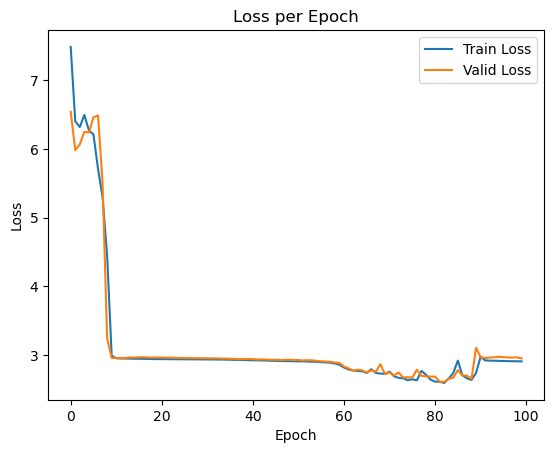

In [3]:
plt.plot([x.cpu().detach().numpy() for x in trnLoss], label = "Train Loss")
plt.plot([x.cpu().detach().numpy() for x in valLoss], label = "Valid Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()